In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.exposure import equalize_adapthist


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import time

import numpy as np


# import dataset


In [2]:
gt_sanderban = np.genfromtxt('sanderban_GT.csv', delimiter=',')

In [3]:
class Landcover:
    
    def __init__(self, rasters_list):
        
        self.rasters = rasters_list
        self.model_input = None
        self.width = 0
        self.height = 0
        self.depth = 0
        self.no_of_ranges = None
        self.models = None
        self.predicted_rasters = None
        self.s_scores = []
        self.inertia_scores = []
        self.gt_kmeans = None
        self.X_scaled = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
         
        
    def set_raster_stack(self):
        #self.rasters = self.rasters.sort()
        l = []
        for i in self.rasters:
          with rio.open(i, 'r') as f:
            l.append(f.read(1))

        # Data
        arr_st = np.stack(l)
        print(arr_st.shape)
        self.depth, self.height, self.width = arr_st.shape
        x = np.moveaxis(arr_st, 0, -1)
        print(x.shape)
        #self.model_input = bands_stack.reshape(self.width * self.height, self.depth)
        self.model_input = x.reshape(-1, self.depth)
        print(self.model_input.shape)


     
    def preprocessing(self):

        
        scaler = StandardScaler().fit(self.model_input)

        X_scaled = scaler.transform(self.model_input)

        #X_scaled.shape, gt_kmeans.shape
    
        self.X_scaled = X_scaled
        return self.X_scaled.shape
                
          
    def classification(self, clf,param_dist, gt):
        start_time = time.time()


        # Define the outer loop of k-fold cross-validation
        outer_cv = KFold(n_splits=5, shuffle=True, random_state=200)

        # Define the inner loop of RandomizedSearchCV
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=200)
        search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=inner_cv, random_state=200)

        # Perform nested cross-validation
        nested_scores = []
        for train_index, test_index in outer_cv.split(self.X_scaled, gt):
            search.fit(self.X_scaled[train_index], gt[train_index])
            score = search.score(self.X_scaled[test_index], gt[test_index])
            print(score)
            nested_scores.append(score)

        
        #--------------
        
        elapsed_time = time.time() - start_time
        print("La durée d'exécution est de : {}s".format(elapsed_time))
        
        final_model = search.best_estimator_
        print("Les meilleurs parametres sont :")
        print(search.best_params_)
        
        #print(metrics.accuracy_score(self.y_test, clf_pred))
        
        
        predicted = final_model.predict(self.X_scaled)
  
        acc = (metrics.accuracy_score(gt, predicted))*100
        print("L'accuracy est de : {}".format(acc))
        
        # calcul du kappa 
        kappa = cohen_kappa_score(gt, predicted)
        print("La valeur de Kappa: {}".format(kappa))
        
        # visualisation du resultat obtenu
        print("Classification finale")
        ep.plot_bands(predicted.reshape((self.height, self.width)),   #self.height, self.width
                      cmap ='Accent')
        plt.show()
        
        # matrice de confusion
        print("Matrice de confusion")
        plot_confusion_matrix(final_model, self.X_scaled,gt)
        
        
            
            
            
            
 
            
            
            

In [7]:
S_sentinel_bands = glob("Sanderband/*B?*.tiff")

In [8]:
S_sentinel_bands.sort()

In [9]:
S_sentinel_bands

['Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B12_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B8A_(Raw).tiff']

In [10]:
sanderband_dataset = Landcover(S_sentinel_bands)
sanderband_dataset.set_raster_stack()

(12, 954, 298)
(954, 298, 12)
(284292, 12)


In [11]:
sanderband_dataset.preprocessing()

(284292, 12)

In [12]:

param_dist = {'n_neighbors': [7,10,15,20],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski'],
              'algorithm': ['brute', 'kd_tree','auto'],
              }

knn = KNeighborsClassifier()

/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

0.9896234545102798


/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

0.9894827555883853


/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

0.9900102008512435


/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

0.9900629638749164


/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

0.9890252910760139
La durée d'exécution est de : 1488.3760368824005s
Les meilleurs parametres sont :
{'weights': 'distance', 'n_neighbors': 20, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
L'accuracy est de : 99.78050736566628
La valeur de Kappa: 0.9972927090331424
Classification finale


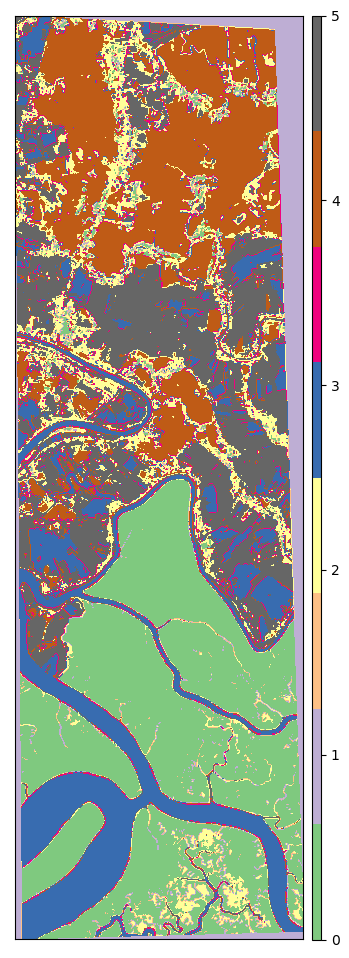

Matrice de confusion


/Users/tchouar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


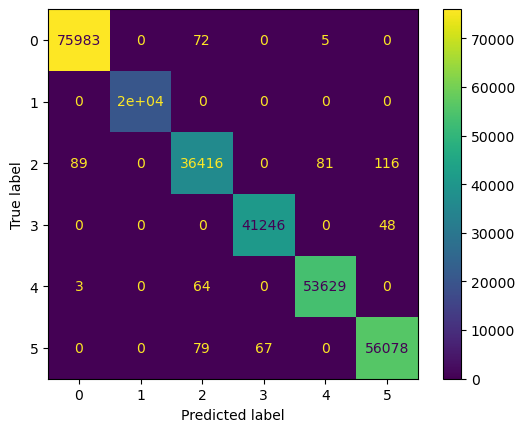

In [13]:
sanderband_dataset.classification(knn,param_dist,gt_sanderban)